<a href="https://colab.research.google.com/github/aryanfaghihi/ai-course/blob/master/Image%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Make a copy

**Follow the following steps to make your own copy. You will lose your changes if you don't make your own copy!**

From the tooltip above, you should see 

File | Edit | View | Insert | Runtime | Tools | Help

1. Click on **File**
2. Click on **Save a copy in Drive**

## Import

Let's import the required packages and setup some settings that will help us in this notebook.

In [104]:
# install required packages
!pip install "torch==1.4" "torchvision==0.5.0"

In [105]:
# import the required packages
from fastai.vision import *
from google.colab import files

# Data

Today, we will be creating another `classifier`. It will be able to classify different breeds of cats and dogs. More information on the **Pets dataset** [here](https://www.robots.ox.ac.uk/~vgg/data/pets/).

Let's download the dataset first.

In [106]:
# download and extract the dataset
path = untar_data(URLs.PETS)

Next, we will view the folder structure to see where the `images` can be found

In [107]:
# view the folder structure
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

Let's read the images from the `images` folder

In [108]:
# import the images from `/images` folder
images = ImageList.from_folder(path/'images')

It's always a good idea to plot a batch of images to make sure everything is working.

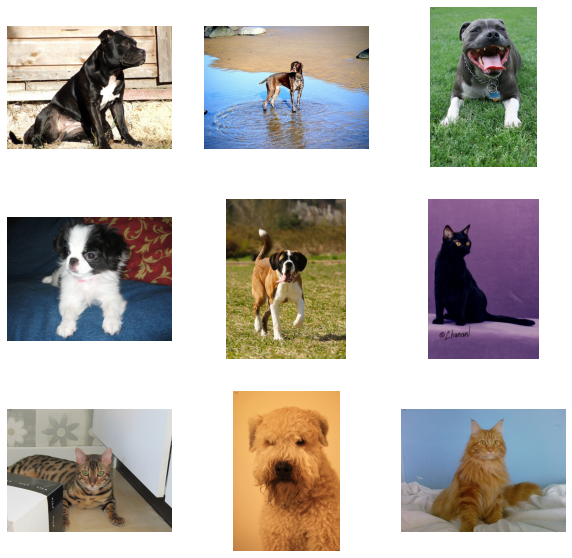

In [109]:
# CHANGE these values to get more images
rows = 3
columns = 3

# DON'T CHANGE THIS PART
_, axs = plt.subplots(rows, columns, figsize=(10,10))
for i,ax in enumerate(axs.flatten()): 
  images[i].show(ax=ax)

You will notice that images are missing labels, but that's ok. We will add the labels later. For now, we will shift our focus on **Augmentation**.

## Augmentation

Data augmentation is one of the most important techniques used when training a model for Computer Vision. Instead of feeding the model with the same images, we will alter these images slightly so that the model's prediction can be more generalised. 

Augmentation could be as simple as flipping an image horizontally or changing the brightness of an image. Basically anything that changes the image enough to be considered a *different* image but the object within the image is still recognisable.

> Augmentation is a great technique to increase the size of your dataset without having to download more images

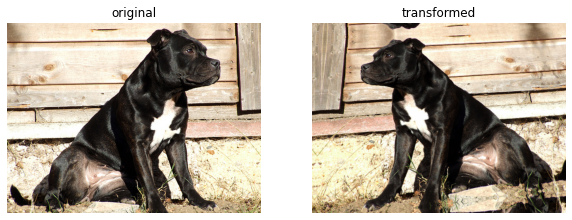

In [110]:
# create a list of recommended transforms
tfsm = get_transforms()

# pick an image
img = images[0]

# apply transforms
transformed_img = img.apply_tfms(tfsm[0])

# view the original and transformed image
_, axs = plt.subplots(1, 2, figsize=(10,10))
img.show(axs[0], title='original')
transformed_img.show(axs[1], title='transformed')

---

What changes can you see? 

Try running the cell again, do you see the same transformed image? Why do you think that is?

---

Next we will look at a few common augmentations.

### Flip

As the name suggests, a horizontal is one of the most common augmentations. This is because a horizontal flip generally does not fundamentally change the meaning of an image.

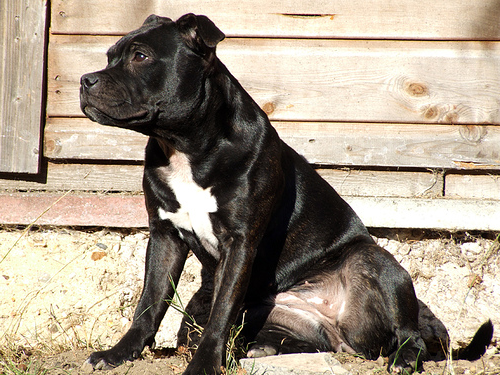

In [111]:
# flip horizantally
flip_tfm = [flip_lr()]

# apply the transform
img.apply_tfms(flip_tfm)

---

Can you think of an image that is not logical to be horizontally flipped?

---

### Rotate

Rotating is also another populat augmentation. You could argue that flipping is a special case of rotation. In practice, rotation is usually between 30 and 60 degrees as most objects still remain recognisable with rotation.

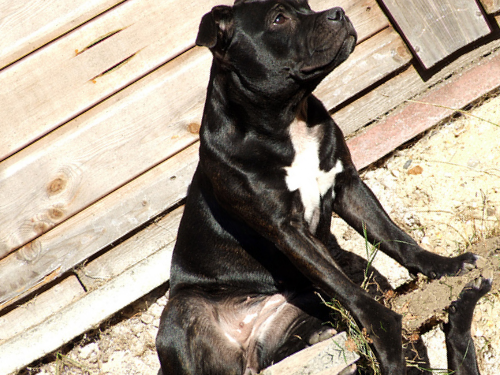

In [112]:
# rotate image
rotate_tfm = [rotate(degrees=30)]

# apply the transform
img.apply_tfms(rotate_tfm)

---

Can you think of an example where rotation fundamentally changes the meaning of an image?

---

### Zoom

Zooming is slightly less popular than the other two methods as it will remove valuable information from the image. Although you can argue that removing parts of the image will make the model more *robust*.

Only thing to keep in mind when using `zoom` us to make sure the object in the image is still *recognisable*. 

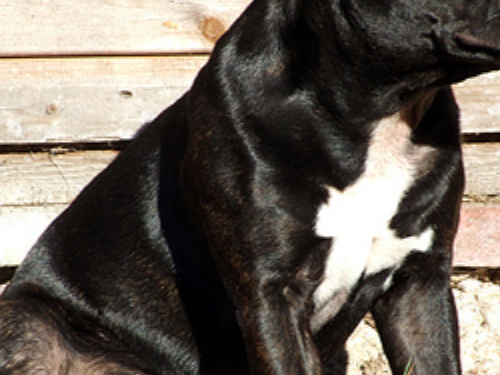

In [113]:
# zoom 2 times
zoom_tfm = [zoom(scale=2)]

# apply the transformation
img.apply_tfms(zoom_tfm)

### Brightness

Augmentating the brightness of the image is not as straightforward as the other techniques. You would have to be very careful how much you change the brightness by. You generally want to change the brightness by only 10-20% as this is not likely to make the image unrecognisable.

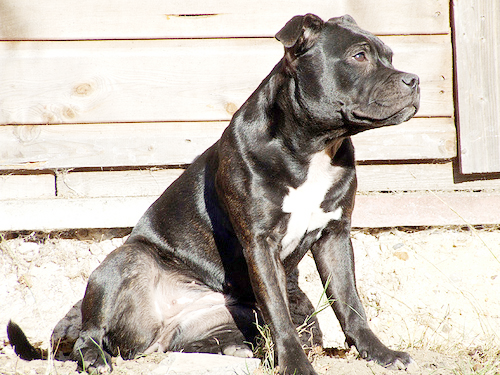

In [114]:
# change brightness 
## change = 0.1 -> very dark
## change = 0.5 -> original
## change = 0.9 -> very bright
bright_tfm = [brightness(change=0.8)]

# apply the transformation
img.apply_tfms(bright_tfm)

### Warp

This is probably one of the coolest ones as it gives the image a different perspective. Again, you'd have to mindful of changing the persepective, the image, as always, needs to remain recognisable.

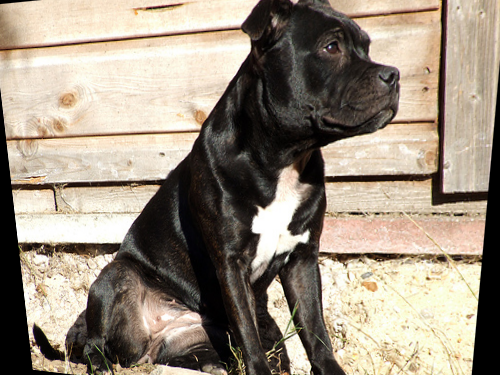

In [115]:
# symmetric warp transformation
warp_tfm = [symmetric_warp(magnitude=(-0.3, 0.3))]

# apply the transformation
## padding_mode='zeros' adds dark pixels around the image
img.apply_tfms(warp_tfm, padding_mode='zeros')

### Jitter

Last one we will cover today is to add jitter to the image. Again, you'd want to only apply a reasonable magnitude of `jitter`.

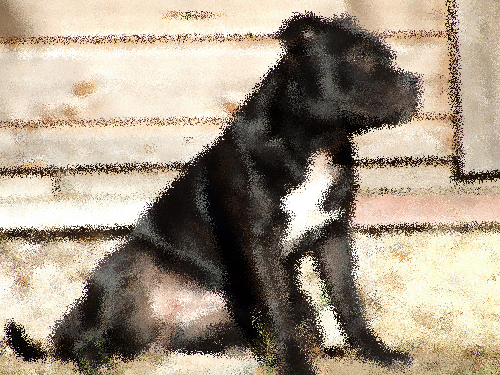

In [116]:
# jitter transformation
## magnitude is between -1 and 1
jit_tfm = [jitter(magnitude=0.02)]

# applt the transformation
img.apply_tfms(jit_tfm)

You might have noticed that we kept saying **recognisable**. This is super important. If you change the image so much that even *you* can't recognise the object in it, you should not expect the model to learn anything meaninful from it. 

Always think about the model as your little sibling and that you are trying to teach them about various objects. You should not expect the model to have super-intelligence. It's all about pattern recognition! (we humans are pretty good at that).

## Dataloader

Before moving on to the next step, let's create the dataloader. 

You do not need to know how this section works exactly but you are more than welcome to read up on the [documentation](https://docs.fast.ai/vision.data.html).

In [117]:
# define the regex pattern to treat the filename as label
pattern = r'/([^/]+)_\d+.jpg$'

# define the path of images
path_img = path/'images'

# read the name of the image files
fnames = get_image_files(path_img)

# define the transformations
tfms = get_transforms(do_flip=True,     # flip
                      max_rotate=10,    # rotation
                      max_zoom=1.1,     # zoom
                      max_lighting=0.2) # brightness

data = ImageDataBunch.from_name_re(path_img, 
                                   fnames, 
                                   pattern, 
                                   ds_tfms=tfms,
                                   size=224,
                                   bs=128,
                                  ).normalize(imagenet_stats)

Side note on transformations
> Previously we used a different syntax to just demonstrate what each transformation looks like. In practice we always use `get_transforms()` and pass a set of parameters like shown above. Of course, you can also set all the other transformations discussed prviously manually but that is beyond the scope of this course. But you can always read up on it [here](https://docs.fast.ai/vision.transform.html) if you're interested.



Side note on `normalize(imagenet_stats)`
> Remember how we did normalization back when we did tabular data? The aim back then was to reduce the spread of continuous variables. The same applies here! Images are made up of pixels which are continuous variables and they can have a large spread. We apply normalization to reduce this spread which results in a more accurate model.

# Model

Before starting to make our model. Let's view a batch of our images from our dataloader to make sure everything is working.

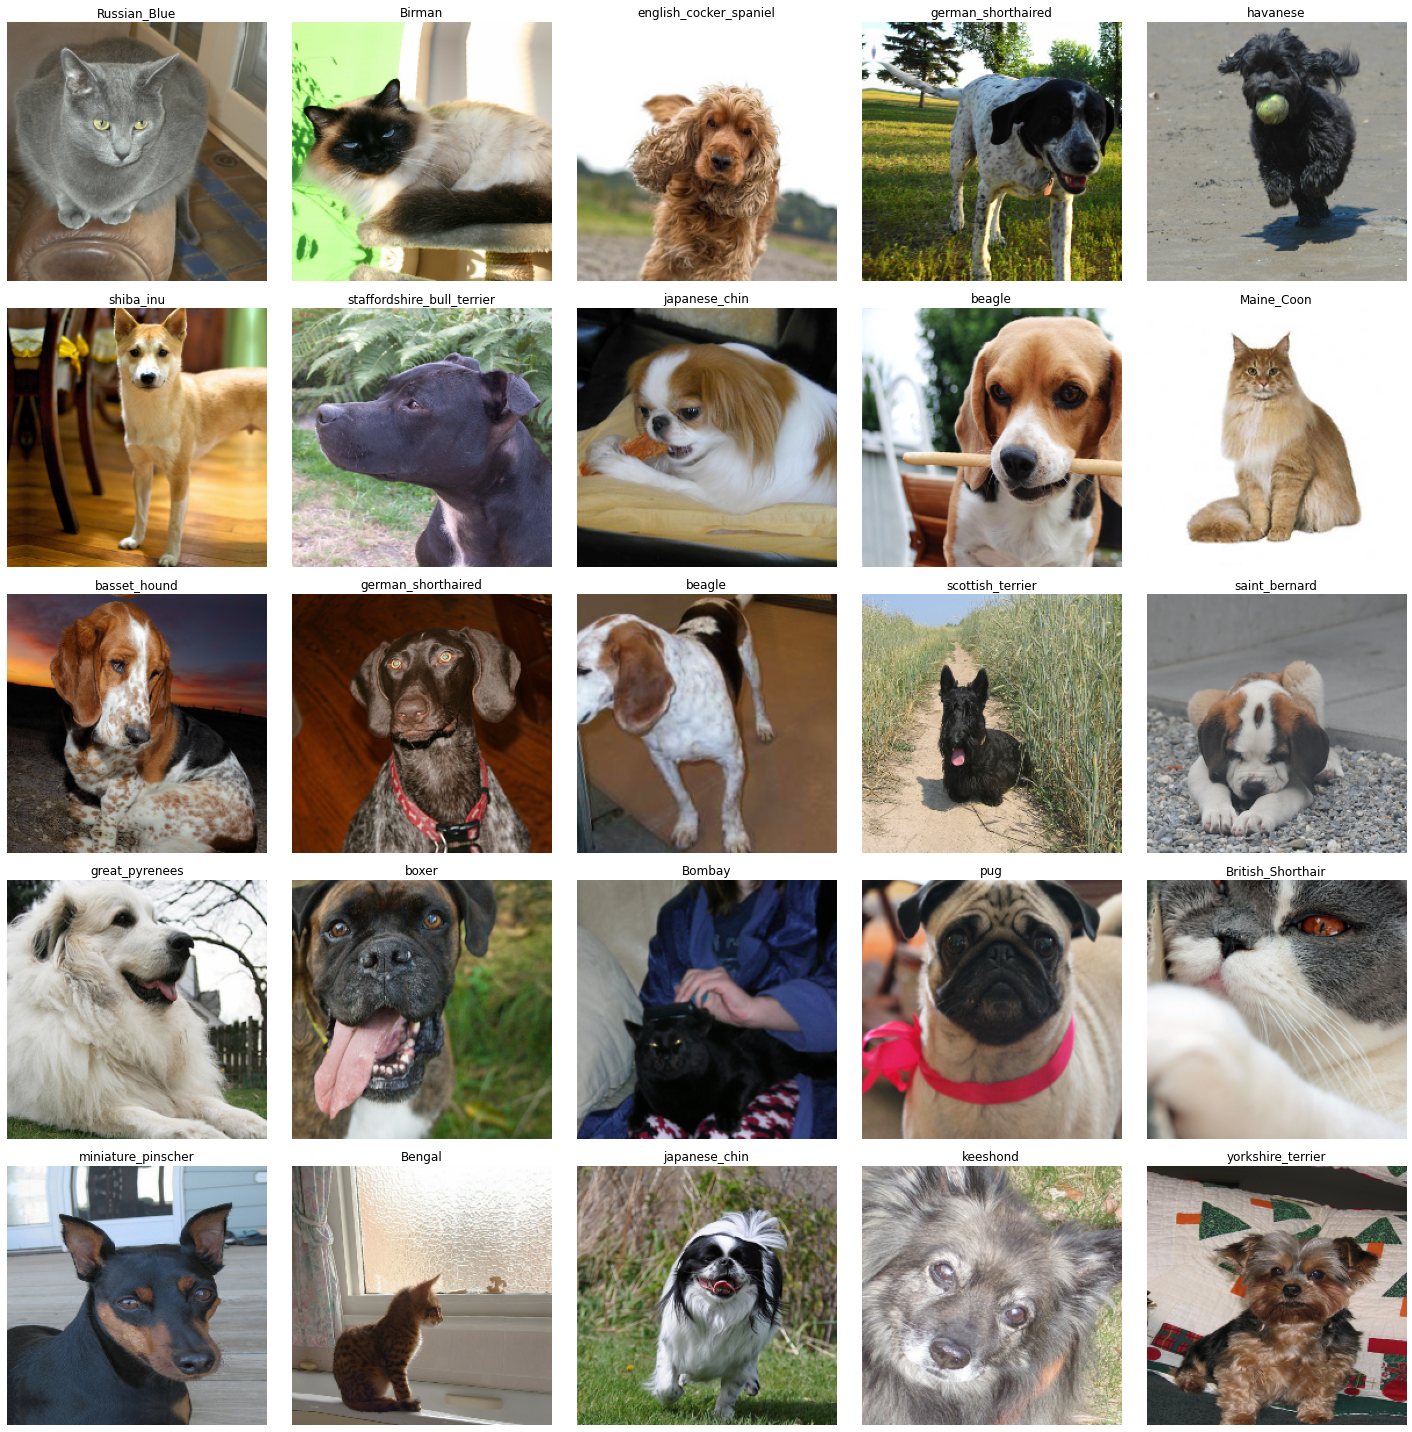

In [118]:
# use `show_batch` to display a batch data
### YOUR CODE HERE

data.show_batch()

## Training

Time to train our model! This the next two lines should be quite familiar to you by now.

In [119]:
# setup the architecture of the model
learn = cnn_learner(data, models.resnet34, metrics=accuracy, callback_fns=ShowGraph)

`fit()` vs `fit_one_cycle()`?

> They both train your model but they use different policies to achieve it. Generally `fit_one_cycle()` is preferred. The details of the differences between the two is out of the scope of this course.

In [127]:
learn.fit_one_cycle(4)

KeyboardInterrupt: ignored

You should also see a plot of `train` loss and `valid` loss.

**Training loss**
This sould always decrease over time. This simply means that your model is learning from the training dataset. You would expect the `loss` to decrease over time in training. 

**Validation loss**
This will decrease at first but it is likely to increase after more training. You would want to stop training once your `valid` loss starts to increase consistently because this means you are memorising your training dataset.

> Imagine you are studying for a maths test and you have memorised the answers to all the textbook questions. Would you get a good mark for your test? no, because you did not *learn* anything, you simply memorised the answers from the textbook. The same applies here. When your `valid` loss starts to increase, your model is cheating by memorising your `train` dataset.  

## Interpretation

In [121]:
# setup the interpretation class
interp = ClassificationInterpretation.from_learner(learn)

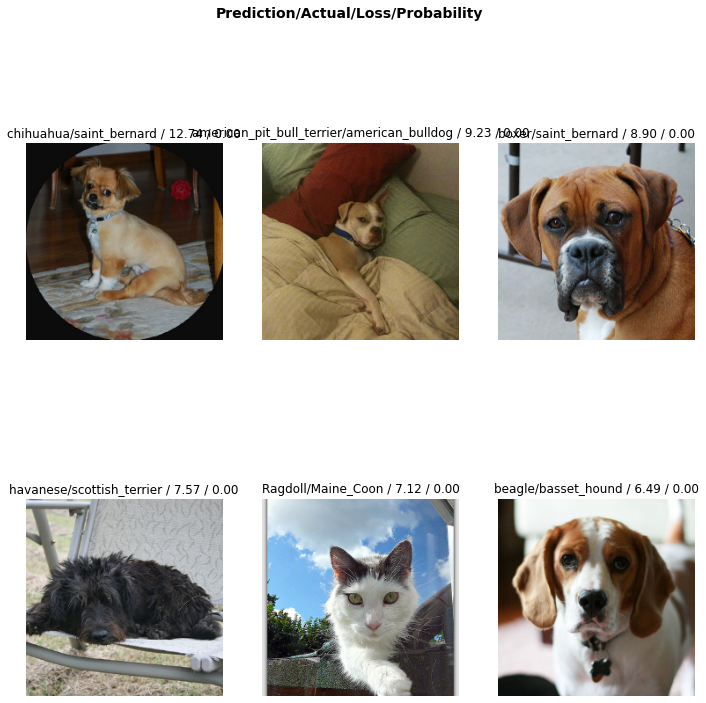

In [122]:
# plot the top losses
interp.plot_top_losses(6)

## Fine-tuning

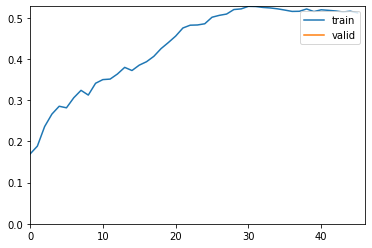

In [123]:
# unfreeze the model to train the entire model
learn.unfreeze()

# start training
learn.fit_one_cycle(1)

Althought this works, it is a much better idea to adjust how fast we are learning. This will ensure that we are fine-tuning our model rather than learning anything from scratch. This is where `learning rate` comes in handy.

> **Learning rate** is how fast the model learns from the data

How de we choose the learning rate? we can use the following code snippet.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


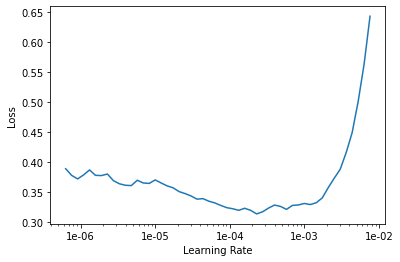

In [124]:
# find appropriate learning rate
learn.lr_find()

# plot the learning rates to choose from
learn.recorder.plot()

You'd want to choose a range from where the model has not gone exponentially high. This is where the model can learn new information without exponentially increasing its loss (which in turn reduces the accuracy)

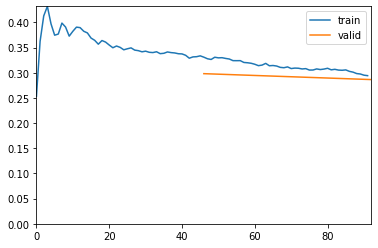

In [125]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

## Testing

Time to test your model with your own image!

Find an image of a cat or a dog online and see if the model can predict it.

Saving persian.jpeg to persian (2).jpeg


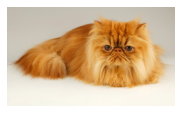

In [128]:
# upload a new image
uploaded = files.upload()

# grab the name of the uploaded image
filename = list(uploaded)[0]

# open the image
image = open_image(filename)

# view the image
show_image(image);

In [129]:
# predict the image!
pred = learn.predict(image)

# print the breed of the cat/dog
data.classes[int(pred[0])]

'Persian'

You can always go back and train a little longer if you didn't get the correct prediction.

# Summary